# Thompson Sampling and the Bernoulli Bandit

Let's explore Thompson sampling as a simple strategy for balancing exploration and exploitation in a (sort of) real-world setting. We'll do this in the simple situation of the two-armed Bernoulli bandit.

### Optimizing Click-Through Rates

Imagine we are trying to compare some proposed process with our current status quo. For example, maybe we're trying to determine if a new e-mail newsletter layout drives click-throughs to our website more often than the layout we're currently using. This problem is an example of a two-armed bandit - we have a choice between two "arms" and we want to discover and select the arm that has the maximum reward. More to the point, we want to balance exploration (determining which arm is the best) and exploitation (pulling the arm that we believe is best) to maximize cumulative payoff. 

After taking each action, we receive a binary reward with the form $\textrm{Reward}_k \sim \textrm{Bernoulli}(\theta _k)$. This is a simple situation to simulate and does reasonably well approximate many real-world bandit problems, where the only two measurable outcomes are success or failure. 

### Simulating the Problem

In order to somewhat approximate reality, let's create a blackbox `EmailOracle` class that represents the information we get about each email view after we send it. Practically speaking, this may be information that lives in analytics database that we need to query, but in this case we'll have it print either `T` or `F` to console, where `T` represents an email view that converted to a click-through. 

We'll intentionally set it up such that the new action has a small but real lift over the status quo, so ideally our online learning algorithm can identify it as the better option.

In [1]:
import numpy as np
from numpy.typing import ArrayLike


class EmailOracle:
    def __init__(self, a: float, b: float):
        self.a = a
        self.b = b

    def status_quo_action(self):
        print(["F", "T"][np.random.binomial(1, self.a)])

    def new_proposed_action(self):
        print(["F", "T"][np.random.binomial(1, self.b)])


two_armed_bandit = EmailOracle(0.05, 0.08)


### Setting up the learning agent

Next, we can use the `bayesianbandits` library to set up a learning agent. First, let's define a learner that will accumulate our best knowledge regarding each arm. Because this is a Bernoulli bandit, we'll use a Dirichlet (multivariate beta) classifier. Because the Dirichlet distribution is the conjugate prior to the Binomial and Multinomial distributions, it will be simple to compute an analytical Bayesian update after each arm pull.

In regards to priors, we'll choose an uninformative $\textrm{Dirichlet}(0.5, 0.5)$ prior, which essentially encodes that we believe either email may be better, but we have no idea how good either will be. 

In [2]:
from bayesianbandits import DirichletClassifier

clf = DirichletClassifier(alphas={"T": 0.5, "F": 0.5})




Next, we need to define functions that represent the action space and function(s) to compute reward. Because we consider an output of `T` a success and an output of `F` a failure, we'll have our reward function return the value of the `T` column of our `clf.classes_` array. 

In [3]:
from enum import Enum

class EmailActions(Enum):
    STATUS_QUO = 0
    NEW_PROPOSAL = 1

    def take_action(self, email: EmailOracle):
        if self == EmailActions.STATUS_QUO:
            email.status_quo_action()
        elif self == EmailActions.NEW_PROPOSAL:
            email.new_proposed_action()

def reward_func(x: ArrayLike) -> ArrayLike:
    return x[..., 0]


Now we can define our learning agent. To do so, we will need the main decorator from the `bayesianbandits` library - `@bandit`. The `@bandit` decorator synthesizes the bandit API on our experiment class.

The `@bandit` takes two arguments, the `learner` which defines how each arm will learn how rewarding its action is, and `policy`, which determines how the agent chooses which arm to pull. In this case, we'll use `thompson_sampling`, which takes no parameters.

In [4]:
from bayesianbandits import (
    Bandit,
    thompson_sampling,
    Arm,
)

class Agent(Bandit, learner=clf, policy=thompson_sampling()):
    status_quo_arm = Arm(EmailActions(0), reward_func)
    new_proposal_arm = Arm(EmailActions(1), reward_func)


agent = Agent()


Now, let's simulate some online learning. To somewhat approximate the process of capturing data and feeding it to the agent, we'll use the `redirect_stdout` decorator to capture the output of our print calls to a `StringIO` object, then update the agent with the last non-newline character of the object. Let's simulate 5000 observations.

In [5]:
from contextlib import redirect_stdout
from io import StringIO


with redirect_stdout(StringIO()) as reward_stream:
    for _ in range(5000):
        action = agent.pull()
        action.take_action(two_armed_bandit)
        agent.update(reward_stream.getvalue()[-2])


Let's see how our agent did. First, we can sample from the posterior distributions of each arm to determine the agent's belief about how rewarding each arm is.

We can see that the new proposal arm has been correctly been identified as the better arm, and the posterior distribution is narrower, suggesting that the agent spent more time pulling that arm.

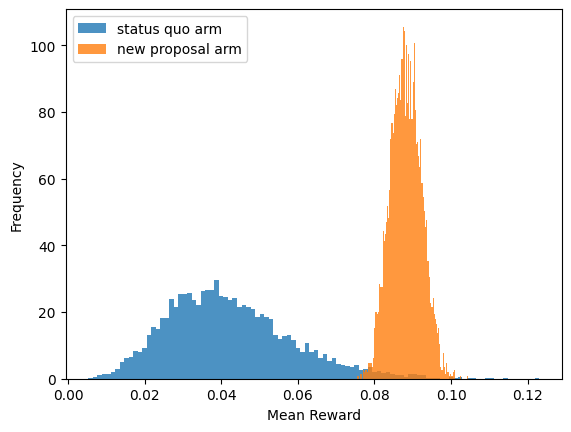

In [6]:
import matplotlib.pyplot as plt

plt.hist(
    agent.status_quo_arm.sample(np.array([[1]]), size=5000),
    alpha=0.8,
    label="status quo arm",
    density=True,
    stacked=True,
    bins=100
)
plt.hist(
    agent.new_proposal_arm.sample(np.array([[1]]), size=5000),
    alpha=0.8,
    label="new proposal arm",
    density=True,
    stacked=True,
    bins=100
)

plt.xlabel("Mean Reward")
plt.ylabel("Frequency")

plt.legend()

plt.show()


This is a sort of contrived situation - in the experiment described above, we wouldn't actually know the reward of each action immediately - in reality, our agent would have to pull several arms, and then at some later point it would need to be updated. To facilitate this, `bayesianbandits` makes a `delayed_reward` option available. Let's redefine our agent using it.

In [7]:
class Agent(Bandit, learner=clf, policy=thompson_sampling(), delayed_reward=True):
    status_quo_arm = Arm(EmailActions(0), reward_func)
    new_proposal_arm = Arm(EmailActions(1), reward_func)


agent = Agent()

`delayed_reward` makes the agent's `pull` and `update` arguments take an additional `unique_id` argument, used to index arm pull events. It is up to the user to define these values, but the agent will internally store which `unique_id` connects to which `arm`, ensuring that we can properly update the arm later.

Let's simulate what that might look like. Our online learning experiment now consists of two steps:

1. Be presented with n choices to make
2. Update the learner with the results of those n choices
3. Repeat some number of times

Let's say that we're going to send out 100 emails a week, and we'll assume, for the sake of this simulation, that we gather data about each of those 100 emails by the end of the week. We'll repeat this process over 10 weeks.

In [8]:
for week in range(10):

    with redirect_stdout(StringIO()) as reward_stream:

        feedback_and_unique_ids: list[tuple[str, str]] = []

        # make 100 pulls per week

        for email_idx in range(100):
            # use week + email_idx as the unique_id
            action = agent.pull(unique_id=f"{week}_{email_idx}")
            action.take_action(two_armed_bandit)
            feedback_and_unique_ids.append((reward_stream.getvalue()[-2], f"{week}_{email_idx}"))
            
        # update the agent with the feedback and unique_ids at the end of the week

        for feedback, unique_id in feedback_and_unique_ids:
            agent.update(feedback, unique_id=unique_id)


We can see from the posterior distribution of each arm that the agent essentially learned the same information it learned above. 

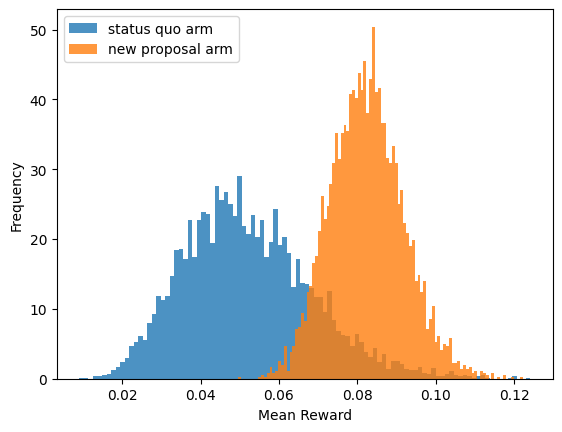

In [9]:
plt.hist(
    agent.status_quo_arm.sample(np.array([[1]]), size=5000),
    alpha=0.8,
    label="status quo arm",
    density=True,
    stacked=True,
    bins=100
)
plt.hist(
    agent.new_proposal_arm.sample(np.array([[1]]), size=5000),
    alpha=0.8,
    label="new proposal arm",
    density=True,
    stacked=True,
    bins=100
)

plt.xlabel("Mean Reward")
plt.ylabel("Frequency")

plt.legend()

plt.show()


Let's add another touch of realism to our above example. We're not actually going to leave our code running all week - we want to run a job on Monday to send all of the emails, and then run a separate job on Sunday to update the agent. There are innumerable ways to do this, but the simplest is to use the `joblib` package, which is utilized by `scikit-learn` to simplify model persistence. Agents created by `bayesianbandits` are also fully-compatible with `joblib`, as long as the original `@bandit`-decorated class has been defined in whatever code is reloading the agent.

In [10]:
import joblib

joblib.dump(agent, "agent.pkl")

agent = joblib.load("agent.pkl")

Finally, let's add one more layer of realism - perhaps we are concerned about memory usage of the `delayed_reward` cache, and instead want to persist it on disk. While the default behavior of `delayed_reward` is to store the cache in-memory, we can provide it with any `dict`-like object 

In [11]:
import shelve

on_disk_cache = shelve.open("on_disk_cache")

class Agent(Bandit, learner=clf, policy=thompson_sampling(), delayed_reward=True):
    status_quo_arm = Arm(EmailActions(0), reward_func)
    new_proposal_arm = Arm(EmailActions(1), reward_func)


agent = Agent(cache=on_disk_cache)

Now we can repeat the above experiment, but with the knowledge that the agent's memory usage will be small due to storing its `delayed_reward` cache on disk instead of in-memory. This, of course, has some minor performance penalty due to IO.

In [12]:
for week in range(10):

    with redirect_stdout(StringIO()) as reward_stream:

        feedback_and_unique_ids: list[tuple[str, str]] = []

        # make 100 pulls per week

        for email_idx in range(100):
            # use week + email_idx as the unique_id
            action = agent.pull(unique_id=f"{week}_{email_idx}")
            action.take_action(two_armed_bandit)

            feedback_and_unique_ids.append((reward_stream.getvalue()[-2], f"{week}_{email_idx}"))
            
        # update the agent with the feedback and unique_ids at the end of the week

        for feedback, unique_id in feedback_and_unique_ids:
            agent.update(feedback, unique_id=unique_id)

Once again, the agent learned that the new policy is better. 

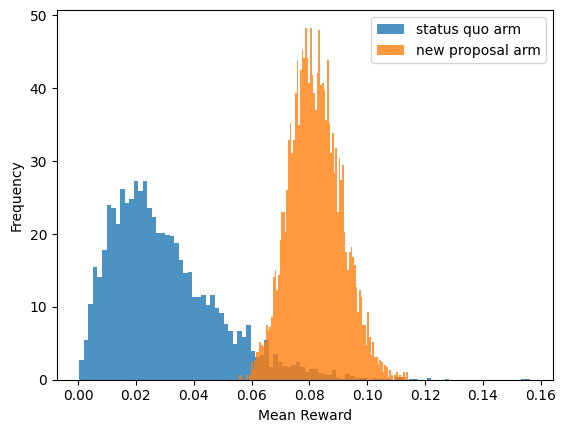

In [13]:
plt.hist(
    agent.status_quo_arm.sample(np.array([[1]]), size=5000),
    alpha=0.8,
    label="status quo arm",
    density=True,
    stacked=True,
    bins=100
)
plt.hist(
    agent.new_proposal_arm.sample(np.array([[1]]), size=5000),
    alpha=0.8,
    label="new proposal arm",
    density=True,
    stacked=True,
    bins=100
)

plt.xlabel("Mean Reward")
plt.ylabel("Frequency")

plt.legend()

plt.show()